# **ISSCC 2026 Code-a-Chip Challenge**
# **Automated Search Space Exploration of Transformer HW/SW Co-design**
## Author: Xinting Jiang, Minxing Chu - Brown University

xinting_jiang@brown.edu

Please feel free to reach out!

## Transformer Architecture Design Space

Considering the gpt2-like decoder-only transformer structure, it would have the follow parameter config variations.

<p align="center">
  <img src="images/transformer_sw.png" alt="Transformer Architecture" style="width: 50%;">
</p>

### **Table of Parameters**

| Symbol | Parameter | Description | 
|:--:|:--|:--|
| $\text{n\_embd}$ | Model dimension | Hidden size of layer $\ell$ |
| $\text{n\_head}$ | Attention heads | Number of parallel attention heads | 
| $\text{mlp\_ratio}$ | MLP expansion ratio | Expansion ratio in feedforward block | 
| $\text{block\_size}$ | Block size | Number of visible tokens per query | 
| $\text{n\_layers}$ | Layers | Number of Layer |

Consider a homogeneous architecture (i.e. each layer shares the same setting), the search space could be configured in the following block

In [10]:
# Interactive search-space controls
!pip install ipywidgets
from ipywidgets import widgets
from IPython.display import display, clear_output


def show_config(max_n_layers,
                n_embd_min, n_embd_max, n_embd_step,
                mlp_min, mlp_max, mlp_step,
                bs_min, bs_max, bs_step,
                max_n_heads):
    print(f"Maximum number of layers: {max_n_layers}")
    print(f"Embedding dimension range: min={n_embd_min}, max={n_embd_max}, step={n_embd_step}")
    print(f"MLP ratio range: min={mlp_min}, max={mlp_max}, step={mlp_step}")
    print(f"Block size range: min={bs_min}, max={bs_max}, step={bs_step}")
    print(f"Maximum number of heads: {max_n_heads}")

    # Basic validation feedback
    errs = []
    if n_embd_step <= 0:
        errs.append("Embedding step must be > 0")
    if n_embd_min > n_embd_max:
        errs.append("Embedding min cannot be greater than max")

    if mlp_step <= 0:
        errs.append("MLP ratio step must be > 0")
    if mlp_min > mlp_max:
        errs.append("MLP ratio min cannot be greater than max")

    if bs_step <= 0:
        errs.append("Block size step must be > 0")
    if bs_min > bs_max:
        errs.append("Block size min cannot be greater than max")

    if errs:
        print("\nIssues:")
        for e in errs:
            print(" -", e)


# Wider labels so full names are visible
label_style = {"description_width": "initial"}

# Widgets with full names
w_max_n_layers = widgets.IntSlider(
    value=12, min=1, max=64, step=1,
    description="Max n_layers",
    style=label_style,
)

# Embedding (d_model) range
w_n_embd_min = widgets.IntText(
    value=256, description="Embedding dimension (min)",
    style=label_style,
)
w_n_embd_max = widgets.IntText(
    value=768, description="Embedding dimension (max)",
    style=label_style,
)
w_n_embd_step = widgets.IntText(
    value=64, description="Embedding dimension (step)",
    style=label_style,
)

# MLP ratio range
w_mlp_min = widgets.IntText(
    value=1, description="MLP ratio (min)",
    style=label_style,
)
w_mlp_max = widgets.IntText(
    value=8, description="MLP ratio (max)",
    style=label_style,
)
w_mlp_step = widgets.IntText(
    value=1, description="MLP ratio (step)",
    style=label_style,
)

# Block size range
w_bs_min = widgets.IntText(
    value=256, description="Block size (min)",
    style=label_style,
)
w_bs_max = widgets.IntText(
    value=2048, description="Block size (max)",
    style=label_style,
)
w_bs_step = widgets.IntText(
    value=64, description="Block size (step)",
    style=label_style,
)

# Heads
w_max_n_heads = widgets.IntSlider(
    value=8, min=1, max=64, step=1,
    description="Max n_heads",
    style=label_style,
)

ui = widgets.VBox([
    w_max_n_layers,
    widgets.HBox([w_n_embd_min, w_n_embd_max, w_n_embd_step]),
    widgets.HBox([w_mlp_min, w_mlp_max, w_mlp_step]),
    widgets.HBox([w_bs_min, w_bs_max, w_bs_step]),
    w_max_n_heads,
])

out = widgets.Output()


def _refresh_output(*_):
    with out:
        clear_output(wait=True)
        show_config(
            w_max_n_layers.value,
            w_n_embd_min.value, w_n_embd_max.value, w_n_embd_step.value,
            w_mlp_min.value, w_mlp_max.value, w_mlp_step.value,
            w_bs_min.value, w_bs_max.value, w_bs_step.value,
            w_max_n_heads.value,
        )


for _w in [
    w_max_n_layers,
    w_n_embd_min, w_n_embd_max, w_n_embd_step,
    w_mlp_min, w_mlp_max, w_mlp_step,
    w_bs_min, w_bs_max, w_bs_step,
    w_max_n_heads,
]:
    _w.observe(_refresh_output, names="value")

_refresh_output()

# Apply button to save into variables
apply_btn = widgets.Button(description="Apply to variables", button_style="success")
status = widgets.HTML()


def _on_apply_clicked(_):
    global max_n_layers, n_embd, mlp_ratio, block_size, max_n_heads, config

    # Validate before save
    errs = []
    if w_n_embd_step.value <= 0:
        errs.append("Embedding step must be > 0")
    if w_n_embd_min.value > w_n_embd_max.value:
        errs.append("Embedding min cannot be greater than max")

    if w_mlp_step.value <= 0:
        errs.append("MLP ratio step must be > 0")
    if w_mlp_min.value > w_mlp_max.value:
        errs.append("MLP ratio min cannot be greater than max")

    if w_bs_step.value <= 0:
        errs.append("Block size step must be > 0")
    if w_bs_min.value > w_bs_max.value:
        errs.append("Block size min cannot be greater than max")

    if errs:
        status.value = "<span style='color:red'>" + "; ".join(errs) + "</span>"
        return

    max_n_layers = w_max_n_layers.value
    max_n_heads = w_max_n_heads.value
    n_embd = {
        "min": w_n_embd_min.value,
        "max": w_n_embd_max.value,
        "step": w_n_embd_step.value,
    }
    mlp_ratio = {
        "min": w_mlp_min.value,
        "max": w_mlp_max.value,
        "step": w_mlp_step.value,
    }
    block_size = {
        "min": w_bs_min.value,
        "max": w_bs_max.value,
        "step": w_bs_step.value,
    }
    config = dict(
        max_n_layers=max_n_layers,
        n_embd=n_embd,
        mlp_ratio=mlp_ratio,
        block_size=block_size,
        max_n_heads=max_n_heads,
    )

    status.value = (
        "<span style='color:green'>Saved: max_n_layers, n_embd {min,max,step}, mlp_ratio {min,max,step}, "
        "block_size {min,max,step}, max_n_heads, and config</span>"
    )


apply_btn.on_click(_on_apply_clicked)

display(ui, out, apply_btn, status)


Output()

Button(button_style='success', description='Apply to variables', style=ButtonStyle())

HTML(value='')

## Check the Search Space Configuration

In [9]:
# Example: use the saved variables
try:
    print("max_n_layers:", max_n_layers)
    print("n_embd:", n_embd)
    print("max_n_heads:", max_n_heads)
    print("\nConfig dict:", config)
except NameError:
    print("Variables not set yet. Run the previous cell and click 'Apply to variables'.")

max_n_layers: 12
n_embd: {'min': 256, 'max': 768, 'step': 64}
max_n_heads: 8

Config dict: {'max_n_layers': 12, 'n_embd': {'min': 256, 'max': 768, 'step': 64}, 'mlp_ratio': {'min': 1, 'max': 8, 'step': 1}, 'block_size': {'min': 256, 'max': 1024, 'step': 256}, 'max_n_heads': 8}


## Inspect Search Space Size -- Homogeneous Architecture

Inspect the size of the search space -- only considering variations on the software side

In [11]:
# Import the search_space.py next to this notebook's folder and build a space from the UI variables
import sys
from pathlib import Path
import importlib

# Ensure the nsga_search directory (parent of this notebook) is on sys.path
nb_dir = Path().resolve()              # .../nsga_search/notebooks
src_dir = nb_dir.parent                # .../nsga_search
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

num_configs = 0 

for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
    for n_heads in range(1, max_n_heads + 1):
        if n_embdin % n_heads == 0:
            num_configs += (mlp_ratio["max"] - mlp_ratio["min"] + 1) * ((block_size["max"] - block_size["min"]) // block_size["step"] + 1)
            
num_configs *= max_n_layers  # arbitrary number of layers, each can be any of the configurations

print(f"Number of possible configurations in the search space: {num_configs}")


Number of possible configurations in the search space: 125280


### Mapping to Transformer Accelerator Hardware 

We designed a custom transformer accelerator which can run Transformer models defined above. 

<p align="center">
  <img src="images/transformer_hw.png" alt="Transformer Architecture" style="width: 50%;">
</p>

Figure (a) decribed the overall architecture of the systolic array based transformer accelerator, Figure (b) describes the structure with in a single core. 

We can explore this hardware search space with the parameters and constraints defined in the table below:

| Parameter | Description | Range |
|:--:|:--|:--|
| $\text{n\_row}$ | Number of rows in the systolic array | keep the same number as the head size | 
| $\text{n\_col}$ | Number of columns in the systolic array | [1,64] | 
| $\text{n\_mac}$ | Number of mac units  | [4,8,16,32] | 
| $\text{wmem\_depth}$ | Block size | [128,256,512,768,1024,1536,2048,2560,3072,3584,4096,5120,6144,7168,8192] | 
| $\text{kv\_cache\_depth}$ | Layers | [128,256,512,768,1024,1536,2048,2560,3072,3584,4096,5120,6144,7168,8192] |

The computation for each head will be mapped onto one row of the systolic array by design. So we have n_row always equal to n_head.

To adapt to the dataflow decribed in the figure, we have the following constraint for the n_mac and n_cols: 

<p align="center"> ( n_embd / n_head / n_col ) % n_mac == 0 </p>
<p align="center"> block_size % n_mac == 0</p>

<p align="center">
  <img src="images/n_cols_description.png" alt="Transformer Architecture" style="width: 50%;">
</p>

Based on the hardware search space description here, the hardware-software co-design space can be enlarged to the following size.

In [17]:
max_n_col = 64
max_n_mac = 32

num_hw_sw_configs = 0   
num_hw_sw_raw_configs = 0

def is_feasible(n_embd, n_heads, n_cols, n_macs, max_context_length) -> bool:
    """Check if the suggestion is feasible."""

    if n_embd % n_heads != 0:
        # print(f"n_embd {n_embd} is not divisible by n_heads {n_heads}. Reject suggestion.")
        return False
    
    head_dim = int(n_embd/n_heads)
    if head_dim % n_cols != 0:
        # print(f"head_dim {head_dim} is not divisible by n_cols {n_cols}. Reject suggestion.")
        return False
    
    core_dim = int(head_dim/n_cols)
    if core_dim % n_macs != 0:
        # print(f"core_dim {core_dim} is not divisible by mac_num {mac_num}. Reject suggestion.")
        return False
    
    if max_context_length % n_cols != 0:
    #   print(f"max_context_length {max_context_length} is not divisible by n_cols {n_cols}. Reject suggestion.")
      return False

    return True

for block_size_val in range(block_size["min"], block_size["max"] + 1, block_size["step"]):
    for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
        for n_heads in range(1, max_n_heads + 1):
            if n_embdin % n_heads != 0:
                continue
            for n_col in range(1, max_n_col + 1):
                for n_mac in range(1, max_n_mac + 1):
                    num_hw_sw_raw_configs += (mlp_ratio["max"] - mlp_ratio["min"] + 1)
                    if is_feasible(n_embdin, n_heads, n_col, n_mac, max_context_length=block_size_val):
                        num_hw_sw_configs += (mlp_ratio["max"] - mlp_ratio["min"] + 1) 

print(f"Number of hardware-software co-design configurations in the search space: {num_hw_sw_raw_configs}. After filtering infeasible ones: {num_hw_sw_configs}.")
print(f"The HW/SW co-design search space is {num_hw_sw_configs/num_configs:.2f}x larger than the SW-only search space.")


Number of hardware-software co-design configurations in the search space: 2949120. After filtering infeasible ones: 55256.
The HW/SW co-design search space is 3.20x larger than the SW-only search space.


## HW Evaluation Methods

Mapping SRAM configuration for each PE:

Below is a compact summary of the SRAM blocks mapped per PE, with their width and depth expressions (using the search-space symbols):

| Name | Width | Depth |
|:--|:--:|:--:|
| KV cache | `n_mac * 8` | `block_size * n_embd * 2 / n_row / n_col / n_mac` |
| WMEM     | `n_mac * 8` | `(mlp_ratio * n_embd**2 + 2 * mr * n_embd) / n_row / n_col / n_mac` |

For convenience, we round up the sram depth to the nearest value in this list: `[128,256,512,768,1024,1536,2048,2560,3072,3584,4096,5120,6144,7168,8192]`

The way we did HW sweeping is by sweeping the configurations for each core(PE) in `sky130` pdk and then aggregate the hw metrics analytically. We use the hw metrics data after the synthesis step.

The folling figure describes the flow to get hardware metrics(PPA)

<p align="center">
  <img src="images/ppa_flow.png" alt="Transformer Architecture" style="width: 50%;">
</p>

Let's start wuth sweeping the search space for one core(PE).


In [ ]:
!git clone https://github.com/zymeng3001/pyPPA.git
# tools needed: yosys, opensta
!python nov_arch_explore/core_top_sweep.py
# estimated finish time: 12 hours
# fetch the results
!python nov_arch_explore/sweep_data_extraction.py

To save time, I put the extracted data in the ref_data folder `ref_data/core_top_sweep_extracted_data.csv`. 

### Sweep SW-HW design points

We also sweep the software design points with decoder-only architecture with size of 100M. We provided the data in the ref_data folder `ref_data/sw_sweep_data.csv`

The following figure presents the sweeping process.
<p align="center">
  <img src="images/sweep_flow.png" alt="Transformer Architecture" style="width: 50%;">
</p>

We will demo the sw and hw data matching process next.

In [2]:
# iterate through the sw swweep data and map it to sw_hw data
import pandas as pd
import numpy as np
import math

# Load data again
file_path = './ref_data/core_top_sweep_extracted_data.csv'
data = pd.read_csv(file_path)

# Creating a nested dictionary-based database
database = {}

def is_feasible(n_embd, n_heads, n_cols, n_macs, max_context_length) -> bool:
    """Check if the suggestion is feasible."""
    if n_embd % n_heads != 0:
        return False
    head_dim = int(n_embd/n_heads)
    if head_dim % n_cols != 0:
        return False
    core_dim = int(head_dim/n_cols)
    if core_dim % n_macs != 0:
        return False
    if max_context_length % n_cols != 0:
      return False
    return True

def get_cache_depth(n_model, n_heads, n_cols, max_context_length, n_macs) -> int:
    """Get the cache depth based on the suggestion."""
    raw_cache_depth = int(2 * n_model * max_context_length / n_macs / n_cols / n_heads)
    if raw_cache_depth < 128:
        return 128
    elif raw_cache_depth < 256:
        return 256
    else:
        return int(math.ceil(raw_cache_depth / 512) * 512)

def get_wmem_depth(n_model, n_heads, n_cols, n_macs, ffn_ratio) -> int:
    """Get the wmem depth based on the suggestion."""
    raw_wmem_depth = int((4 + 0*ffn_ratio)*(n_model * n_model)/ n_heads / n_cols / n_macs)
    if raw_wmem_depth < 32:
        return 32
    elif raw_wmem_depth < 64:
        return 64
    elif raw_wmem_depth < 128:
        return 128
    else :
        return int(math.ceil(raw_wmem_depth / 512) * 512)
    
def get_TTFT(clk_period, n_model, mac_num, n_heads, n_cols, max_context_length, sequence_length=256 ,n_layers=1, ffn_ratio=4, softmax_choice='SOFTMAX', activation_choice='RELU'):
    """
    Calculate the time to first token (TTFT) based on the design parameters.
    """
    # coerce inputs to numeric types (some callers pass strings)
    n_model = float(n_model)
    mac_num = float(mac_num)
    n_heads = float(n_heads)
    n_cols = float(n_cols)
    max_context_length = float(max_context_length)
    sequence_length = float(sequence_length)
    n_layers = float(n_layers)
    ffn_ratio = float(ffn_ratio)
    # Calculate the token delay for GEMM ops
    TTFT = (4.0 * n_model * n_model + 2.0 * ffn_ratio * n_model * n_model) * 1e-9 * clk_period / gbus_width # load and store delay
    # Number of cycles = Total MACs / (Number of MAC units)
    num_loading_cycles = (4*n_model*n_model*sequence_length + 2*max_context_length*max_context_length*n_model + 2*ffn_ratio*n_model*n_model*sequence_length) / (n_heads*n_cols*mac_num)
    TTFT += num_loading_cycles * clk_period * 1e-9 # seconds
    # add 2 residual delay
    TTFT += 2 * n_model * sequence_length * 1e-9 * clk_period # residual add delay
    # add memory loading delay

    # activation delay is negligible

    TTFT /= 0.9 # assuming 90% efficiency

    TTFT *= n_layers

    return TTFT # convert to s

def get_TPOT(clk_period, n_model, mac_num, n_heads, n_cols, max_context_length, sequence_length=256 ,n_layers=1, ffn_ratio=4, softmax_choice='SOFTMAX', activation_choice='RELU'):
    """
    Calculate the time per output token (TPOT) based on the design parameters.
    """
    # Calculate the token delay
    # for GEMM ops

    # coerce numeric inputs
    n_model = float(n_model)
    mac_num = float(mac_num)
    n_heads = float(n_heads)
    n_cols = float(n_cols)
    max_context_length = float(max_context_length)
    sequence_length = float(sequence_length)
    n_layers = float(n_layers)
    ffn_ratio = float(ffn_ratio)

    TPOT = (4.0 * n_model * n_model + 2.0 * ffn_ratio * n_model * n_model) * 1e-9 * clk_period # load and store delay

    # Number of cycles = Total MACs / (Number of MAC units)
    num_loading_cycles = (4*n_model*n_model + 2*sequence_length*sequence_length*n_model + 2*ffn_ratio*n_model*n_model) / (n_heads*n_cols*mac_num)
    TPOT += num_loading_cycles * clk_period * 1e-9 # seconds

    # add 2 residual delay
    TPOT += 2 * n_model * 1e-9 * clk_period # residual add delay

    # add memory loading delay
    TPOT /= 0.9 # assuming 90% efficiency
    TPOT *= n_layers
    return TPOT # convert to s

# Populating the database with configuration as keys and relevant metrics as values
for _, row in data.iterrows():
    key = (row['MAC NUM'], row['Wmem Depth'], row['Cache Depth'], row['Clock Period (ns) Entered'])
    database[key] = {
        'power': row['Power (W)'],
        'slack': row['Clock Slack (ns)'],
        'clk_min_period': row['Clock_Min_Period'],
        'area': row['Area (um^2)']
        # Additional metrics can be added here as needed
    }

df = pd.read_csv("./ref_data/sw_sweep_data.csv")

n_cols_range = np.arange(1, 99).tolist()
mac_num = [4,8,16,32]
clk_periods = [3,4,5,6]
sequence_length = 256

total_count = 0
feasible_configs = []

for idx, row in df.iterrows():
    n_model = row['n_embd']
    n_heads = row['n_head']
    max_context_length = row['block_size']
    val_loss = row['best_val_loss']
    n_layers = row['n_layer']
    ffn_ratio = row['mlp_expansion_factor']
    for clk_period in clk_periods:
        for n_cols in n_cols_range:
            for n_macs in mac_num:
                if is_feasible(n_model, n_heads, n_cols, n_macs, max_context_length):
                    # Calculate wmem_depth and cache_depth
                    wmem_depth = get_wmem_depth(n_model, n_heads, n_cols, n_macs, ffn_ratio)
                    cache_depth = get_cache_depth(n_model, n_heads, n_cols, max_context_length, n_macs)

                    # Retrieve core power and area from the database
                    core_power = database.get((n_macs, wmem_depth, cache_depth, clk_period), {}).get('power', 'N/A') 
                    core_area = database.get((n_macs, wmem_depth, cache_depth, clk_period), {}).get('area', 'N/A')
                    clk_min_period = database.get((n_macs, wmem_depth, cache_depth, clk_period), {}).get('clk_min_period', 'N/A')
                    slack = database.get((n_macs, wmem_depth, cache_depth, clk_period), {}).get('slack', 'N/A')

                    # calculate perplexity
                    perplexity = math.exp(val_loss) if val_loss != 'N/A' else 'N/A'

                    if core_power != 'N/A' and core_area != 'N/A' and clk_min_period != 'N/A':
                        total_count += 1
                        gbus_width = n_macs * 8
                        ttft = get_TTFT(clk_min_period, n_model, n_macs, n_heads, n_cols, max_context_length, ffn_ratio=ffn_ratio, n_layers=n_layers, sequence_length=sequence_length)
                        tpot = get_TPOT(clk_min_period, n_model, n_macs, n_heads, n_cols, max_context_length, ffn_ratio=ffn_ratio, n_layers=n_layers, sequence_length=sequence_length)
                        throughput = 1/(tpot) if tpot != 0 else 'N/A'

                        total_area = core_area * n_heads * n_cols
                        total_power = core_power * n_heads * n_cols
                        feasible_configs.append({
                            'n_embd': n_model,
                            'n_head': n_heads,
                            'block_size': max_context_length,
                            'n_layer': n_layers,
                            'mlp_expansion_factor': ffn_ratio,
                            'n_cols': n_cols,
                            'MAC NUM': n_macs,
                            'Wmem Depth': wmem_depth,
                            'Cache Depth': cache_depth,
                            'best_val_loss': val_loss,
                            'perplexity': perplexity,
                            'Power (W)': total_power,
                            'Area (um^2)': total_area,
                            'Clock Period (ns) Entered': clk_period,
                            'Clock_Min_Period': clk_min_period,
                            'F_max (MHz)': 1000/clk_min_period if clk_min_period != 0 else 'N/A',
                            'Clock Slack (ns)': slack,
                            'TTFT (ms)': ttft * 1000,
                            'TPOT (ms)': tpot * 1000,
                            'Throughput (tokens/s)': throughput,
                            'Energy per token (mJ/token)': total_power / throughput * 1000,
                            'EDP (mJ * ms)': (total_power/throughput/1e6) * ttft,
                            'EADP (mJ * ms * um^2)': (total_power/throughput/1e6) * ttft * total_area
                        })

print(f"Total number of feasible configurations: {total_count}")
feasible_df = pd.DataFrame(feasible_configs)

# Save to CSV
feasible_csv_path = './ref_data/sweep_data_sw_hw.csv'
feasible_df.to_csv(feasible_csv_path, index=True)



Total number of feasible configurations: 5288


scatter plots with the three main metrics: val_loss, TTFT, Energy per token

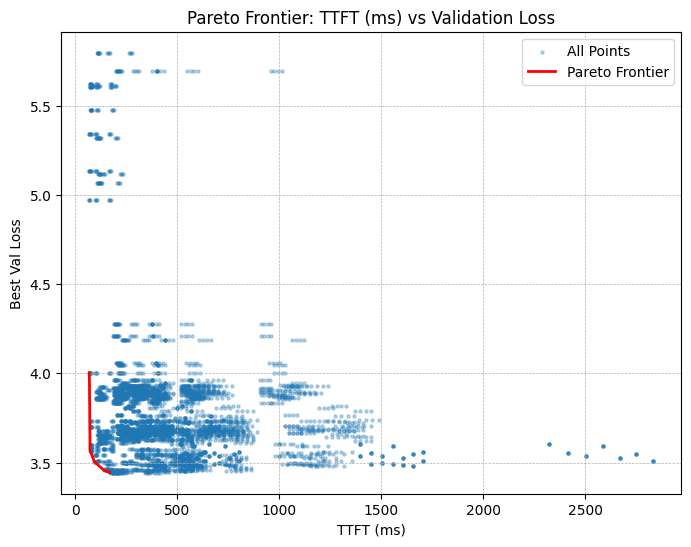

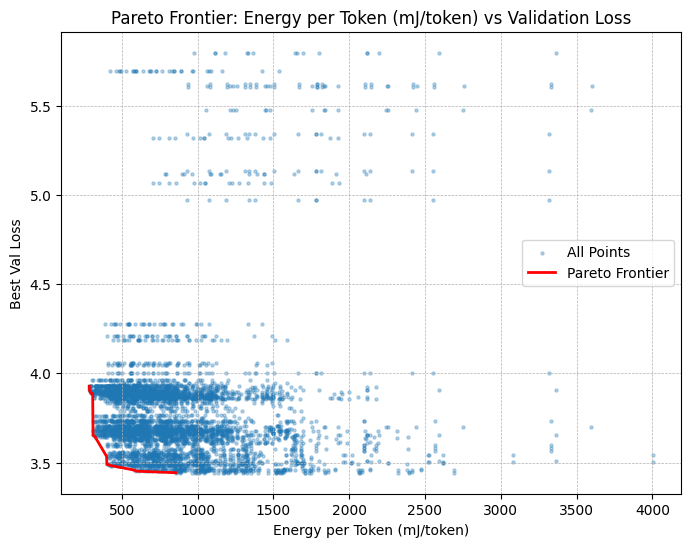

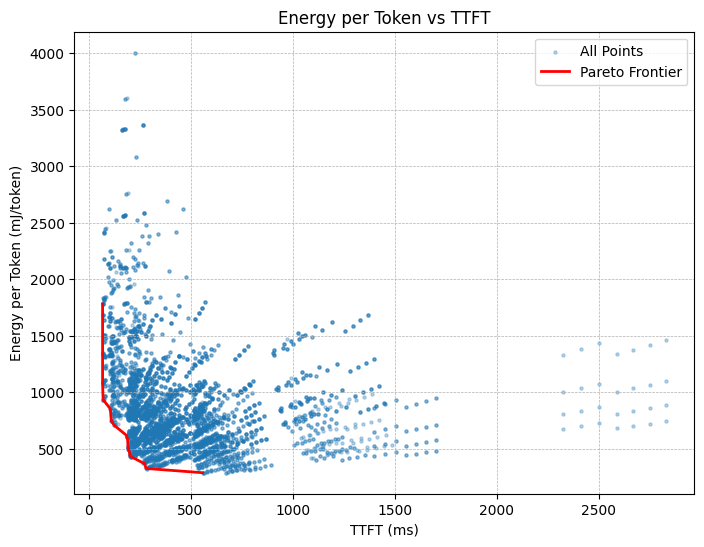

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reload the newest dataset
file_path = "./ref_data/sweep_data_sw_hw.csv"
df = pd.read_csv(file_path)

# Clean column names
df = df.rename(columns=lambda x: x.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_"))

# Normalize EDP and EADP for comparison
df["EDP_norm"] = (df["EDP_mJ_*_ms"] - df["EDP_mJ_*_ms"].min()) / (df["EDP_mJ_*_ms"].max() - df["EDP_mJ_*_ms"].min())
df["EADP_norm"] = (df["EADP_mJ_*_ms_*_um^2"] - df["EADP_mJ_*_ms_*_um^2"].min()) / (df["EADP_mJ_*_ms_*_um^2"].max() - df["EADP_mJ_*_ms_*_um^2"].min())

# Function for Pareto frontier
def pareto_frontier(df, x, y):
    points = df[[x, y]].values
    points = points[np.argsort(points[:, 0])]
    frontier = []
    min_y = np.inf
    for px, py in points:
        if py < min_y:
            frontier.append((px, py))
            min_y = py
    return np.array(frontier)

# Metrics to plot separately
metrics = {
    # "Power_W": "Power (W)",
    # "Area_um^2": "Area (um^2)",
    "TTFT_ms": "TTFT (ms)",
    # "TPOT_ms": "TPOT (ms)",
    "Energy_per_token_mJ_token": "Energy per Token (mJ/token)",
    # "EDP_norm": "Normalized EDP",
    # "EADP_norm": "Normalized EADP"
}

# Generate 5 separate figures
for metric, label in metrics.items():
    pareto = pareto_frontier(df, metric, "best_val_loss")
    
    plt.figure(figsize=(8,6))
    plt.scatter(df[metric], df["best_val_loss"], s=5, alpha=0.3, label="All Points")
    plt.plot(pareto[:,0], pareto[:,1], c="red", linewidth=2, label="Pareto Frontier")
    plt.xlabel(label)
    plt.ylabel("Best Val Loss")
    plt.title(f"Pareto Frontier: {label} vs Validation Loss")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.show()
    # plt.savefig(f"../plots/pareto/pareto_{metric}.png", dpi=500)

# plot best_val_loss as the color map on TTFT vs Energy per token scatter plot
pareto = pareto_frontier(df, "TTFT_ms", "Energy_per_token_mJ_token")
plt.figure(figsize=(8,6))
plt.scatter(df["TTFT_ms"], df["Energy_per_token_mJ_token"], s=5, alpha=0.3, label="All Points")
plt.plot(pareto[:,0], pareto[:,1], c="red", linewidth=2, label="Pareto Frontier")
plt.xlabel("TTFT (ms)")
plt.ylabel("Energy per Token (mJ/token)")
plt.title("Energy per Token vs TTFT")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.show()

## Beyond Traditional Transformer Architecture

The above exploration is based on gpt2-like transformer architecture, while the modern edge scale language models have adopted architectural variation to boost model effiency.

### From Homogeneous to Heterogeneous Architecture

With heterogeneous architecture, each layer can have different parameters such as number of heads and mlp size. Now if we consider the paramter range we set before, we could have a much larger search space by allowing heterogeneous architecture. As we can see from the following calculation, the total number of feasible designs go up to astronomical figures.

<p align="center">
  <img src="images/hetero.png" style="width: 50%;">
</p>

In [13]:
# Build specs from interactive values and instantiate the search space
try:
    # Globals belong in globals_spec
    gspec = {
        "d_model": {"type": "int", "low": n_embd["min"], "high": n_embd["max"], "step": n_embd["step"]},
    }
    # Per-layer fields go into layer_spec
    lspec = {
        "n_heads": {"type": "int", "low": 1, "high": max_n_heads, "step": 1},
        "block_size": {"type": "int", "low": block_size["min"], "high": block_size["max"], "step": block_size["step"]},
        "mlp_ratio": {"type": "int", "low": mlp_ratio["min"], "high": mlp_ratio["max"], "step": mlp_ratio["step"]},
        "attn_type": {"type": "cat", "choices": ["mha"]},
    }
    print("Search space ready. L_max =", max_n_layers)
except NameError:
    print("Variables not set yet. Run the interactive cell above and click 'Apply to variables'.")
    
num_configs_het = 0 

for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
    for n_heads in range(1, max_n_heads + 1):
        if n_embdin % n_heads == 0:
            num_configs_het += (mlp_ratio["max"] - mlp_ratio["min"] + 1) * ((block_size["max"] - block_size["min"]) // block_size["step"] + 1)
            
num_configs_het = num_configs_het ** max_n_layers  # Each layer can be any of the configurations

# use scientific notation if too large
print(f"Number of possible configurations in the search space: {num_configs_het:.2e} {num_configs_het // num_configs :.2e}x larger than the homogeneous space")

Search space ready. L_max = 12
Number of possible configurations in the search space: 1.68e+48 1.34e+43x larger than the homogeneous space


###  Introducing Infinite Attention

Original MHA has this disadvantage that the n_head and head_dim are tight to the number of embeddings, this will restrict us from exploring possibilities of head pruning and different layer sizes。

We introduce Infinite Attention, in which head_dim does not have to be n_embd/n_head and v_head_dim and qk_head_dim can be different, enabling us to explore a broader search space.

<p align="center">
  <img src="images/infinite_attention.png" style="width: 50%;">
</p>

The figure above shows the structure of Infiite Attention.

## Multi-Objective Optimization of Transformer SW Architecture Enabled by NSGA-II Architecture

As mentioned before, now the size of the entire search space has gone up to a astronomical figure. Sweeping through each feasible design point becomes unrealistic. We need a smarter algorithm to help us explore new design points efficiently. Here we decide to implement NSGA2, a multi-objective variant of the genetic algorithm for the optimization strategy. 

<p align="center">
  <img src="images/nsga_framework.png" style="width: 75%;">
</p>


We run the algorithm over our Infinite Attention architecture based heterogeneous search space.

<p align="center">
  <img src="images/exp_settings.png" style="width: 60%;">
</p>

<p align="center">
  <img src="images/exp_results.png" style="width: 60%;">
</p>

Preliminary results show our models advancing toward the accuracy–size Pareto front, outperforming GPT-2 small.